#  DFT Edge Enhancement

The idea is adopted from Shitole et al. They used Discrete Fourier Transform (DFT), high pass filtering, and boxcar filtering to extract edge information. The extracted (and denoised) edge information is then overlaid over a despeckled image to enhace edge information. We replicate the idea here and experiment with some changes.

Steps:
1. Filter image I with 7x7 Boxcar --> S
2. Extract Edge Information --> E
     1. Transform image I to frequency domain
     2. Apply high pass filter (rectangular radius 6, optimal value found by Shitole et al)
     3. Transform back to image domain --> D
     4. Convert image D to binary image --> B 
     5. Filter image D with boxcar (3x3) --> K
3. Impose E on image S (ie. pixels of K as determined by B)

Experiment:
1. Iterate over different radius: {4, 5, ..., 10}
2. Change Boxcar 7x7 with BM3D (5x5, sigma_psd=30)

References:
- https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm
- https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/
- https://bioimagebook.github.io/chapters/2-processing/3-thresholding/thresholding.html
- https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_otsu
- https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html
- https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft2.html#numpy.fft.ifft2
- https://stackoverflow.com/questions/66935821/how-to-apply-a-lpf-and-hpf-to-a-fft-fourier-transform

In [ ]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from astropy.convolution import convolve as ap_convolve
from astropy.convolution import Box2DKernel

## Demo (BM3D with sigma_psd 30 + Edge Information with radius 6)

In [1]:
sample_image = 'sentinel-1_image_VH_2018-10-11.png'

### 1. BM3D Image

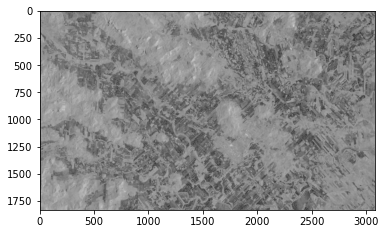

In [3]:
bm3d_image = cv2.imread('../results/bm3d_images/sigma_psd_30/' + sample_image, cv2.IMREAD_GRAYSCALE)
plt.imshow(bm3d_image, cmap='gray')

### 2. Extract Edge Information

Code structure is adopted from https://stackoverflow.com/questions/66935821/how-to-apply-a-lpf-and-hpf-to-a-fft-fourier-transform. (Last accessed on March 29, 2024, 9:41pm, Edmonton Canada Time).

#### 2.A. Discrete Fourier Transform

In [4]:
def image_to_dft(image):
    dft = np.fft.fft2(image, axes=(0,1))
    dft_shift = np.fft.fftshift(dft)
    return dft, dft_shift

In [5]:
# read input and convert to grayscale
image = cv2.imread('../results/selected_images/' + sample_image, cv2.IMREAD_GRAYSCALE)
dft, dft_shift = image_to_dft(image)

# generate spectrum from magnitude image (for viewing only)
mag = np.abs(dft_shift)
spec = np.log(mag)

DFT (not shifted)

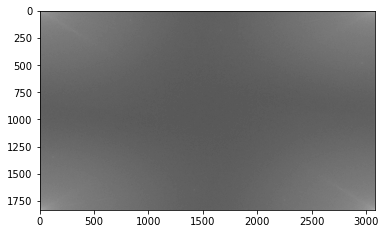

In [6]:
plt.imshow(np.log(np.abs(dft)), cmap='gray')

Mag represents the magnitude

In [7]:
dft[0][0]

(803496696.9999999+9.42964106798172e-09j)

In [8]:
np.abs(dft[0][0])

803496696.9999999

Shifted DFT

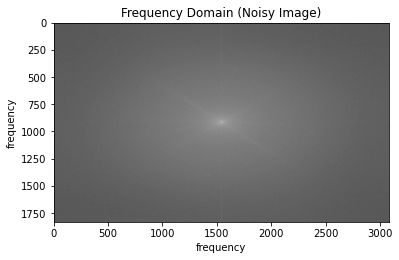

In [9]:
plt.title('Frequency Domain (Noisy Image)')
plt.xlabel('frequency')
plt.ylabel('frequency')
plt.imshow(spec, cmap='gray')

916


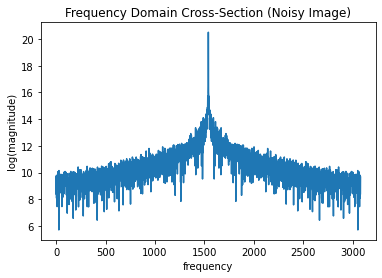

In [10]:
# Cross-section
midline = spec.shape[0] // 2 # abs(height / 2)
print(midline)
plt.title('Frequency Domain Cross-Section (Noisy Image)')
plt.ylabel('log(magnitude)')
plt.xlabel('frequency')
plt.plot(spec[midline, :])

#### 2.B. High Pass Filter

In [11]:
def high_pass_mask(image, radius):
    mask = np.ones_like(image)
    mid_x = mask.shape[0] // 2 
    mid_y = mask.shape[1] // 2
    mask[
        mid_x-radius:mid_x+radius+1,
        mid_y-radius:mid_y+radius+1,
    ] = 0
    return mask

In [12]:
mask = high_pass_mask(image, 6)
masked_spec = spec * mask

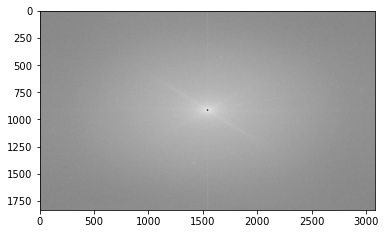

In [13]:
plt.imshow(masked_spec, cmap='gray')

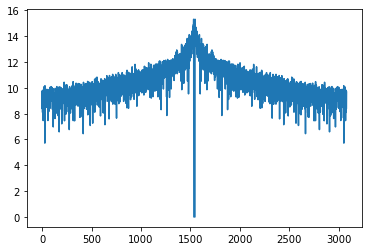

In [14]:
plt.plot(masked_spec[midline, :])

In [15]:
masked_dft = dft_shift * mask

#### 2.C. Inverse DFT

In [16]:
def dft_to_image(dft):
    inverse_dft_shift = np.fft.ifftshift(dft) 
    inverse_image = np.fft.ifft2(inverse_dft_shift, axes=(0,1))
    return np.abs(inverse_image)

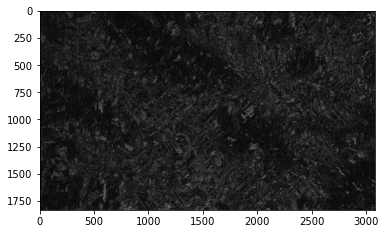

In [17]:
masked_image = dft_to_image(masked_dft)
plt.imshow(masked_image, cmap='gray')

#### 2.D. Binary Image

In [18]:
bw_image = masked_image > threshold_otsu(masked_image)
bw_image = bw_image.astype('int')
bw_image

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

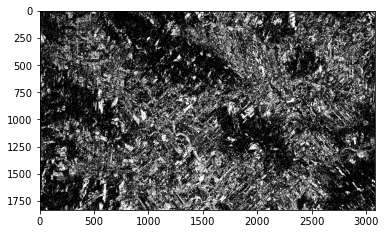

In [19]:
plt.imshow(bw_image * 255, cmap='gray')

#### 2.E. Filter Masked Image with Boxcar (3x3)

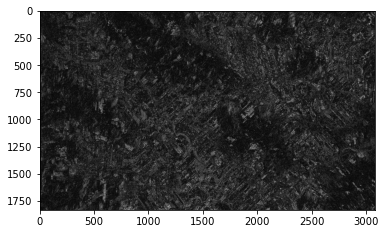

In [20]:
edge_smooth = ap_convolve(masked_image, Box2DKernel(3), normalize_kernel=True)
plt.imshow(edge_smooth, cmap='gray')

### 3.  Overlay edge information over BM3D image

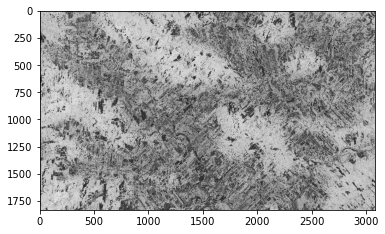

In [21]:
edge = np.array(edge_smooth * bw_image)
result = bm3d_image.copy()
result[edge > 0] = edge[edge > 0]
plt.imshow(result, cmap='gray')

In [22]:
cv2.imwrite('../results/bm3d_edge/demo/' + 'edge_sentinel-1_image_VH_2018-10-11.png', edge)
cv2.imwrite('../results/bm3d_edge/demo/' + 'result_sentinel-1_image_VH_2018-10-11.png', result)
cv2.imwrite('../results/bm3d_edge/demo/' + 'dft_filtered_sentinel-1_image_VH_2018-10-11.png', masked_image)

True

The resulting image is noisy. It introduced more noise to the image.

## Batch Processing

In [29]:
input_dir = '../results/selected_images'
input_files = []
for file in os.listdir(input_dir):
    name, ext = os.path.splitext(file)
    if ext == '.png':
        input_files.append(file)
input_files

['sentinel-1_image_VH_2018-08-12.png',
 'sentinel-1_image_VH_2018-12-10.png',
 'sentinel-1_image_VH_2018-10-11.png',
 'sentinel-1_image_VH_2019-04-09.png',
 'sentinel-1_image_VH_2019-03-04.png',
 'sentinel-1_image_VH_2018-09-05.png',
 'sentinel-1_image_VH_2019-01-03.png',
 'sentinel-1_image_VH_2019-02-08.png',
 'sentinel-1_image_VH_2018-11-04.png']

In [36]:
def add_dft_edge(denoised_image, noisy_image, radius):
    dft, dft_shift = image_to_dft(noisy_image)
    mask = high_pass_mask(noisy_image, radius)
    masked_dft_shift = dft_shift * mask
    masked_image = dft_to_image(masked_dft_shift)
    
    # Boxcar Smoothing (3x3)
    boxcar_image = ap_convolve(masked_image, Box2DKernel(3), normalize_kernel=True)
    
    # Binary Image
    binary_image = masked_image > threshold_otsu(masked_image)
    binary_image = binary_image.astype('int')

    # Overlay Edge
    edge = np.array(boxcar_image * binary_image)
    denoised_image[edge > 0] = edge[edge > 0]
    
    return denoised_image

### Boxcar Base Image (Shitole et al.)

In [38]:
for radius in range(1, 10):
    output_dir = os.path.join('../results/boxcar_edge', f'radius_{radius}')
    os.makedirs(output_dir, exist_ok=True)
    
    for file in input_files:
        print(f'file={file}, radius={radius}')
        output_file = os.path.join(output_dir, file)
        if os.path.exists(output_file):
            print('File exists... skipping this step.')
        else:
            denoised_image = cv2.imread(os.path.join('../results/boxcar/', file), cv2.IMREAD_GRAYSCALE)
            noisy_image = cv2.imread(os.path.join('../results/selected_images/', file), cv2.IMREAD_GRAYSCALE)
            result = add_dft_edge(denoised_image, noisy_image, radius)
            cv2.imwrite(output_file, result)
   

file=sentinel-1_image_VH_2018-08-12.png, radius=1
File exists... skipping this step.
file=sentinel-1_image_VH_2018-12-10.png, radius=1
File exists... skipping this step.
file=sentinel-1_image_VH_2018-10-11.png, radius=1
File exists... skipping this step.
file=sentinel-1_image_VH_2019-04-09.png, radius=1
File exists... skipping this step.
file=sentinel-1_image_VH_2019-03-04.png, radius=1
File exists... skipping this step.
file=sentinel-1_image_VH_2018-09-05.png, radius=1
File exists... skipping this step.
file=sentinel-1_image_VH_2019-01-03.png, radius=1
File exists... skipping this step.
file=sentinel-1_image_VH_2019-02-08.png, radius=1
File exists... skipping this step.
file=sentinel-1_image_VH_2018-11-04.png, radius=1
File exists... skipping this step.
file=sentinel-1_image_VH_2018-08-12.png, radius=2
File exists... skipping this step.
file=sentinel-1_image_VH_2018-12-10.png, radius=2
File exists... skipping this step.
file=sentinel-1_image_VH_2018-10-11.png, radius=2
File exists... 

### BM3D Base Image (sigma_psd = 20)

In [41]:
for radius in range(1, 10):
    output_dir = os.path.join('../results/bm3d_edge', f'radius_{radius}')
    os.makedirs(output_dir, exist_ok=True)
    
    for file in input_files:
        print(f'file={file}, radius={radius}')
        output_file = os.path.join(output_dir, file)
        if os.path.exists(output_file):
            print('File exists... skipping this step.')
        else:
            denoised_image = cv2.imread(os.path.join('../results/bm3d_images/sigma_psd_20/', file), cv2.IMREAD_GRAYSCALE)
            noisy_image = cv2.imread(os.path.join('../results/selected_images/', file), cv2.IMREAD_GRAYSCALE)
            result = add_dft_edge(denoised_image, noisy_image, radius)
            cv2.imwrite(output_file, result)
   

file=sentinel-1_image_VH_2018-08-12.png, radius=1
file=sentinel-1_image_VH_2018-12-10.png, radius=1
file=sentinel-1_image_VH_2018-10-11.png, radius=1
file=sentinel-1_image_VH_2019-04-09.png, radius=1
file=sentinel-1_image_VH_2019-03-04.png, radius=1
file=sentinel-1_image_VH_2018-09-05.png, radius=1
file=sentinel-1_image_VH_2019-01-03.png, radius=1
file=sentinel-1_image_VH_2019-02-08.png, radius=1
file=sentinel-1_image_VH_2018-11-04.png, radius=1
file=sentinel-1_image_VH_2018-08-12.png, radius=2
file=sentinel-1_image_VH_2018-12-10.png, radius=2
file=sentinel-1_image_VH_2018-10-11.png, radius=2
file=sentinel-1_image_VH_2019-04-09.png, radius=2
file=sentinel-1_image_VH_2019-03-04.png, radius=2
file=sentinel-1_image_VH_2018-09-05.png, radius=2
file=sentinel-1_image_VH_2019-01-03.png, radius=2
file=sentinel-1_image_VH_2019-02-08.png, radius=2
file=sentinel-1_image_VH_2018-11-04.png, radius=2
file=sentinel-1_image_VH_2018-08-12.png, radius=3
file=sentinel-1_image_VH_2018-12-10.png, radius=3


## BM3D or Boxcar + Edge but filtering is with DFT, not DFT_shift

The results are "better" than the method above but I observed that it reintroduced noise.

In [44]:
def add_dft_edge_modified(denoised_image, noisy_image, radius):
    dft, dft_shift = image_to_dft(noisy_image)
    mask = high_pass_mask(noisy_image, radius)
    masked_dft = dft * mask
    masked_image = dft_to_image(masked_dft)
    
    # Boxcar Smoothing (3x3)
    boxcar_image = ap_convolve(masked_image, Box2DKernel(3), normalize_kernel=True)
    
    # Binary Image
    binary_image = masked_image > threshold_otsu(masked_image)
    binary_image = binary_image.astype('int')

    # Overlay Edge
    edge = np.array(boxcar_image * binary_image)
    denoised_image[edge > 0] = edge[edge > 0]
    
    return denoised_image

### Boxcar Base

In [46]:
for radius in range(1, 10):
    output_dir = os.path.join('../results/boxcar_edge_modified', f'radius_{radius}')
    os.makedirs(output_dir, exist_ok=True)
    
    for file in input_files:
        print(f'file={file}, radius={radius}')
        output_file = os.path.join(output_dir, file)
        if os.path.exists(output_file):
            print('File exists... skipping this step.')
        else:
            denoised_image = cv2.imread(os.path.join('../results/boxcar', file), cv2.IMREAD_GRAYSCALE)
            noisy_image = cv2.imread(os.path.join('../results/selected_images/', file), cv2.IMREAD_GRAYSCALE)
            result = add_dft_edge_modified(denoised_image, noisy_image, radius)
            cv2.imwrite(output_file, result)
   

file=sentinel-1_image_VH_2018-08-12.png, radius=1
file=sentinel-1_image_VH_2018-12-10.png, radius=1
file=sentinel-1_image_VH_2018-10-11.png, radius=1
file=sentinel-1_image_VH_2019-04-09.png, radius=1
file=sentinel-1_image_VH_2019-03-04.png, radius=1
file=sentinel-1_image_VH_2018-09-05.png, radius=1
file=sentinel-1_image_VH_2019-01-03.png, radius=1
file=sentinel-1_image_VH_2019-02-08.png, radius=1
file=sentinel-1_image_VH_2018-11-04.png, radius=1
file=sentinel-1_image_VH_2018-08-12.png, radius=2
file=sentinel-1_image_VH_2018-12-10.png, radius=2
file=sentinel-1_image_VH_2018-10-11.png, radius=2
file=sentinel-1_image_VH_2019-04-09.png, radius=2
file=sentinel-1_image_VH_2019-03-04.png, radius=2
file=sentinel-1_image_VH_2018-09-05.png, radius=2
file=sentinel-1_image_VH_2019-01-03.png, radius=2
file=sentinel-1_image_VH_2019-02-08.png, radius=2
file=sentinel-1_image_VH_2018-11-04.png, radius=2
file=sentinel-1_image_VH_2018-08-12.png, radius=3
file=sentinel-1_image_VH_2018-12-10.png, radius=3


### BM3D Base

In [45]:
for radius in range(1, 10):
    output_dir = os.path.join('../results/bm3d_edge_modified', f'radius_{radius}')
    os.makedirs(output_dir, exist_ok=True)
    
    for file in input_files:
        print(f'file={file}, radius={radius}')
        output_file = os.path.join(output_dir, file)
        if os.path.exists(output_file):
            print('File exists... skipping this step.')
        else:
            denoised_image = cv2.imread(os.path.join('../results/bm3d_images/sigma_psd_20/', file), cv2.IMREAD_GRAYSCALE)
            noisy_image = cv2.imread(os.path.join('../results/selected_images/', file), cv2.IMREAD_GRAYSCALE)
            result = add_dft_edge_modified(denoised_image, noisy_image, radius)
            cv2.imwrite(output_file, result)
   

file=sentinel-1_image_VH_2018-08-12.png, radius=1
file=sentinel-1_image_VH_2018-12-10.png, radius=1
file=sentinel-1_image_VH_2018-10-11.png, radius=1
file=sentinel-1_image_VH_2019-04-09.png, radius=1
file=sentinel-1_image_VH_2019-03-04.png, radius=1
file=sentinel-1_image_VH_2018-09-05.png, radius=1
file=sentinel-1_image_VH_2019-01-03.png, radius=1
file=sentinel-1_image_VH_2019-02-08.png, radius=1
file=sentinel-1_image_VH_2018-11-04.png, radius=1
file=sentinel-1_image_VH_2018-08-12.png, radius=2
file=sentinel-1_image_VH_2018-12-10.png, radius=2
file=sentinel-1_image_VH_2018-10-11.png, radius=2
file=sentinel-1_image_VH_2019-04-09.png, radius=2
file=sentinel-1_image_VH_2019-03-04.png, radius=2
file=sentinel-1_image_VH_2018-09-05.png, radius=2
file=sentinel-1_image_VH_2019-01-03.png, radius=2
file=sentinel-1_image_VH_2019-02-08.png, radius=2
file=sentinel-1_image_VH_2018-11-04.png, radius=2
file=sentinel-1_image_VH_2018-08-12.png, radius=3
file=sentinel-1_image_VH_2018-12-10.png, radius=3


## Observations

Using DFT to enhance edges does not seem to work with the images tested here. Applying a high pass filter with dft_shift removes homogenous components (retains heterogenous components). Heterogenous components contain edge information AND noise. This step may recognize noise as part of edges. The next step is to denoise this image with boxcar. This step removes noise from the image without homogenous components. Denoising the image with only heterogenous components (edge and noise) with boxcar is ineffective because (1) it blurs the edges again. The method risk reintroducing noise and blured edges. Quantitative analysis will be performed in another notebook. 

## DFT Notes

In [50]:
image = cv2.imread('../results/selected_images/' + sample_image, cv2.IMREAD_GRAYSCALE)
dft, dft_shift = image_to_dft(image)

In [51]:
mag = np.abs(dft_shift)
spec = np.log(mag)

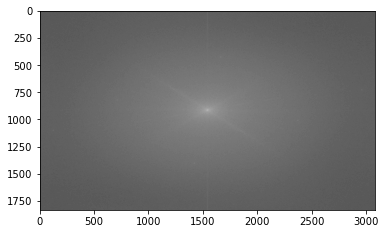

In [54]:
plt.imshow(spec, cmap='gray')

In [56]:
mask = high_pass_mask(image, 6)

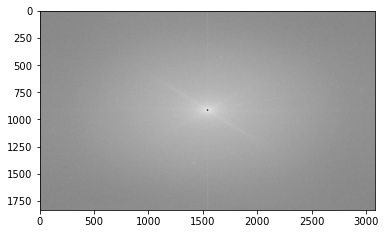

In [57]:
plt.imshow(spec * mask, cmap='gray')

In [59]:
heterogenous_components = dft_to_image(dft_shift * mask)

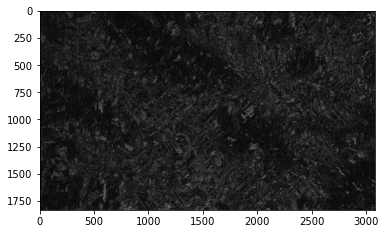

In [61]:
plt.imshow(heterogenous_components, cmap='gray')

In [62]:
def low_pass_mask(image, radius):
    mask = np.zeros_like(image)
    mid_x = mask.shape[0] // 2 
    mid_y = mask.shape[1] // 2
    mask[
        mid_x-radius:mid_x+radius+1,
        mid_y-radius:mid_y+radius+1,
    ] = 1
    return mask

In [63]:
mask = low_pass_mask(image, radius)

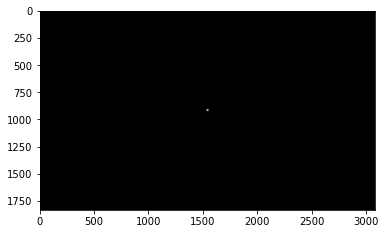

In [64]:
plt.imshow(spec * mask, cmap='gray')

In [67]:
homogenous_components = dft_to_image(dft_shift * mask)

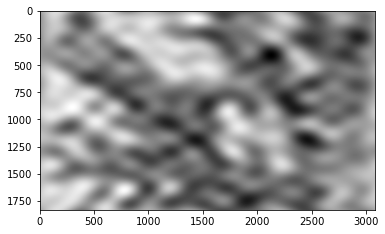

In [68]:
plt.imshow(homogenous_components, cmap='gray')

In [69]:
cv2.imwrite('../results/bm3d_edge/demo/homogenous.jpg', homogenous_components)
cv2.imwrite('../results/bm3d_edge/demo/heterogenous.jpg', heterogenous_components)

True